In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import sys
sys.path.append('../../nnbtplda/scripts/')
import nnlearner

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
data = input_data.read_data_sets('../data/mnist/', one_hot=True) 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
session_1 = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph('../../nnbtplda/models/model_1/-1000.meta')
new_saver.restore(session_1, tf.train.latest_checkpoint('../../nnbtplda/models/model_1/'))
graph = tf.get_default_graph()

tf_in = graph.get_tensor_by_name('Placeholder:0')
tf_out_truth = graph.get_tensor_by_name('Placeholder_1:0')
tf_keep_prob = graph.get_tensor_by_name('Placeholder_2:0')
tf_out_logits = graph.get_tensor_by_name('add_3:0')
tf_out_predicted_p = graph.get_tensor_by_name('Softmax:0')

INFO:tensorflow:Restoring parameters from ../../nnbtplda/models/model_1/-1000


In [4]:
n_steps = 20
learning_rate = .2
category = 0
adversarial_category = 5

imgs = data.test.images[np.argmax(data.test.labels, axis=1) == category]
lbls = data.test.labels[np.argmax(data.test.labels, axis=1) == category]

adversarial_lbls_one_hot = np.zeros(lbls.shape)
adversarial_lbls_one_hot[:, adversarial_category] = 2

In [5]:
tf_losses = tf.nn.softmax_cross_entropy_with_logits(labels=adversarial_lbls_one_hot, logits=tf_out_logits)
tf_gradients = tf.gradients(tf_losses, tf_in)
tf_adversarial_sample = tf.stop_gradient(tf_in - tf.sign(tf_gradients) * learning_rate / n_steps)
tf_adversarial_sample = tf.clip_by_value(tf_adversarial_sample, 0 , 1)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
fake_imgs = imgs.copy()
for i in range(n_steps):
    print(i)
    dydx = session_1.run(tf_gradients, {tf_in: fake_imgs, tf_keep_prob: 1})
    fake_imgs = session_1.run(tf_adversarial_sample, {tf_in: fake_imgs, tf_keep_prob: 1})
    fake_imgs = fake_imgs.reshape(imgs.shape)
    probs = tf_out_predicted_p.eval({tf_in: fake_imgs, tf_out_truth: lbls, tf_keep_prob: 1})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [7]:
model_1_probs = tf_out_predicted_p.eval({tf_in: fake_imgs, tf_out_truth: lbls, tf_keep_prob: 1})
session_1.close()

In [8]:
session_2 = tf.InteractiveSession()
new_saver = tf.train.import_meta_graph('../../nnbtplda/models/model_2/-1000.meta')
new_saver.restore(session_2, tf.train.latest_checkpoint('../../nnbtplda/models/model_2/'))
graph = tf.get_default_graph()

tf_out_predicted_p_model_2 = graph.get_tensor_by_name('Softmax:0')
model_2_probs = tf_out_predicted_p_model_2.eval({tf_in: fake_imgs, tf_out_truth: lbls, tf_keep_prob: 1})
model_2_probs_real_img = tf_out_predicted_p_model_2.eval({tf_in: imgs, tf_out_truth: lbls, tf_keep_prob: 1})
session_2.close()

INFO:tensorflow:Restoring parameters from ../../nnbtplda/models/model_2/-1000


In [9]:
(np.argmax(model_2_probs, axis=1) == 0).mean()

0.976530612244898

In [10]:
(np.argmax(model_1_probs, axis=1) == 0).mean()

0.0010204081632653062

In [11]:
(np.argmax(model_2_probs_real_img, axis=1) == 0).mean()

0.9877551020408163

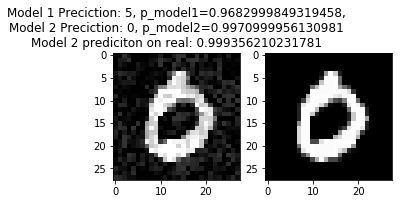

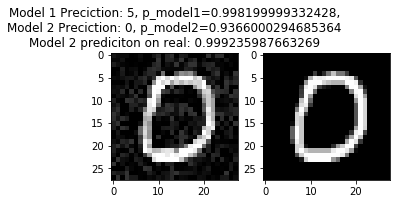

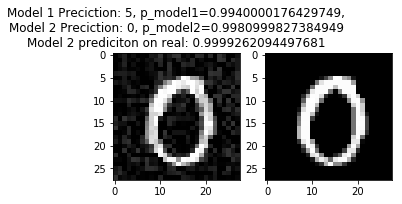

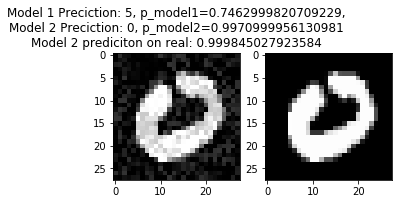

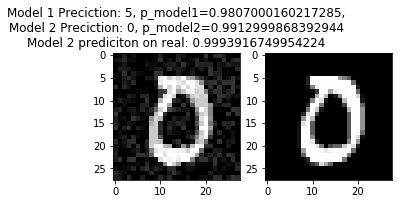

In [14]:
for x in range(5):
    fig, ax_arr = plt.subplots(1, 2, figsize=(5, 2.5))
    ax_arr[0].imshow(fake_imgs[x].reshape(28, 28), cmap='gray')
    ax_arr[1].imshow(imgs[x].reshape(28, 28), cmap='gray')
    args = [np.argmax(model_1_probs[x]),
            np.around(np.max(model_1_probs[x]), 4),
            np.argmax(model_2_probs[x]),
            np.around(np.max(model_2_probs[x]), 4),
            np.max(model_2_probs_real_img[x])]
    ax_arr[0].set_title('Model 1 Preciction: {}, p_model1={},'
                        '\nModel 2 Preciction: {}, p_model2={}'
                        '\nModel 2 prediciton on real: {}'.format(*args))


In [13]:
session_1.graph.get_operations()  

[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'Reshape/shape' type=Const>,
 <tf.Operation 'Reshape' type=Reshape>,
 <tf.Operation 'truncated_normal/shape' type=Const>,
 <tf.Operation 'truncated_normal/mean' type=Const>,
 <tf.Operation 'truncated_normal/stddev' type=Const>,
 <tf.Operation 'truncated_normal/TruncatedNormal' type=TruncatedNormal>,
 <tf.Operation 'truncated_normal/mul' type=Mul>,
 <tf.Operation 'truncated_normal' type=Add>,
 <tf.Operation 'Variable' type=VariableV2>,
 <tf.Operation 'Variable/Assign' type=Assign>,
 <tf.Operation 'Variable/read' type=Identity>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'Variable_1' type=VariableV2>,
 <tf.Operation 'Variable_1/Assign' type=Assign>,
 <tf.Operation 'Variable_1/read' type=Identity>,
 <tf.Operation 'Conv2D' type=Conv2D>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'Relu' type=Relu>,
 <tf.Operation 'MaxPool' type=MaxPool>,
 <tf.Operation 'truncated_norm